# 

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
BASE_DIR = "/kaggle/input/melanoma-cancer-dataset/" 
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")


IMG_SIZE = (224,224)
BATCH_SIZE = 32



train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR, 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary" 
)


test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR, 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

print("Class Mapping:", train_generator.class_indices)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


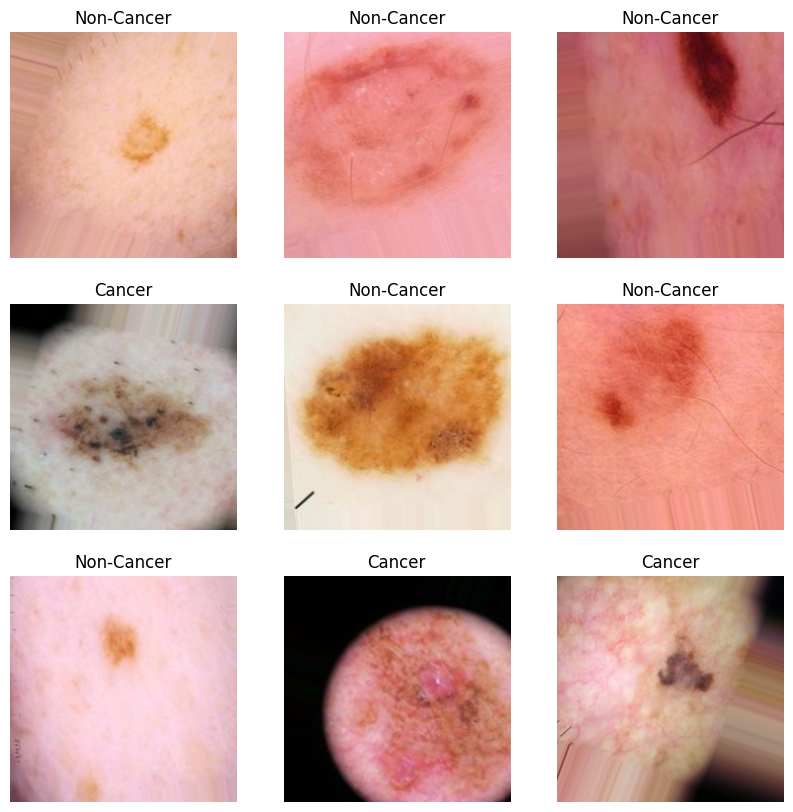

In [8]:
def plot_images(generator):
    images, labels = next(generator)  
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title("Cancer" if labels[i] == 1 else "Non-Cancer")
        plt.axis("off")
    plt.show()


plot_images(train_generator)

In [10]:
from tensorflow.keras import layers, models


model = models.Sequential([
 
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    
   
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
   
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
 
    layers.Flatten(),
    
    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5), 
    layers.Dense(1, activation='sigmoid') 
])


model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']) 


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,  # Stop training after 5 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau to reduce the learning rate if the model stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,  # Reduce LR if no improvement after 3 epochs
    min_lr=1e-7,
    verbose=1
)


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30, 
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 129s 347ms/step - accuracy: 0.8515 - loss: 0.3422 - val_accuracy: 0.8574 - val_loss: 0.3328 - learning_rate: 9.0000e-05
Epoch 2/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7812 - loss: 0.4580 - val_accuracy: 0.8589 - val_loss: 0.3323 - learning_rate: 9.0000e-05
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.8537 - loss: 0.3340 - val_accuracy: 0.8599 - val_loss: 0.3288 - learning_rate: 9.0000e-05
Epoch 4/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8750 - loss: 0.2613 - val_accuracy: 0.8599 - val_loss: 0.3298 - learning_rate: 9.0000e-05
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - accuracy: 0.8569 - loss: 0.3313 - val_accuracy: 0.8679 - val_loss: 0.3144 - learning_rate: 9.0000e-05
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8750 - loss: 0.3409 - val_accuracy: 0.8700 - val_loss: 0.3126 - learning_rate: 9.0000e-05
Epoch 7/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 129s 346ms/

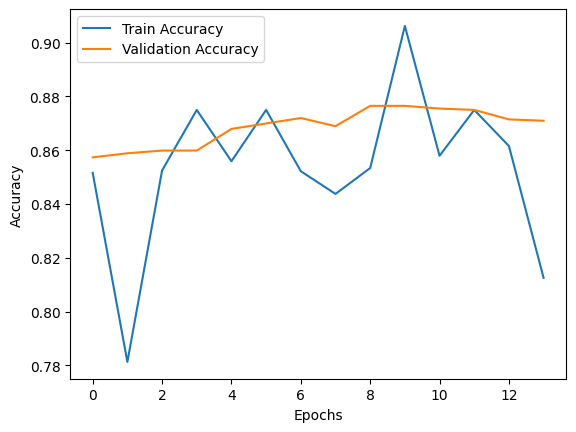

In [13]:
model.save("skin_cancer_cnn.h5")


plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.53      0.51      1000
           1       0.49      0.47      0.48       984

    accuracy                           0.50      1984
   macro avg       0.50      0.50      0.50      1984
weighted avg       0.50      0.50      0.50      1984



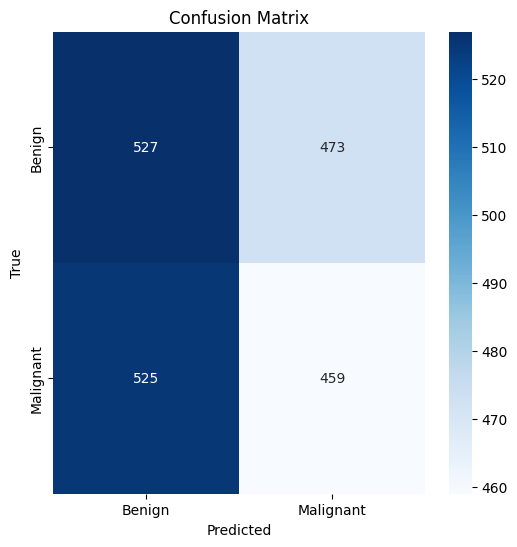

In [14]:

test_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)


test_pred_labels = (test_pred > 0.5).astype("int32")

test_true_labels = test_generator.classes[:len(test_pred_labels)] 


print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels))


cm = confusion_matrix(test_true_labels, test_pred_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


model = load_model('/kaggle/working/skin_cancer_cnn.h5')


def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))  
    img_array = image.img_to_array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0)  

   
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"
    
   
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


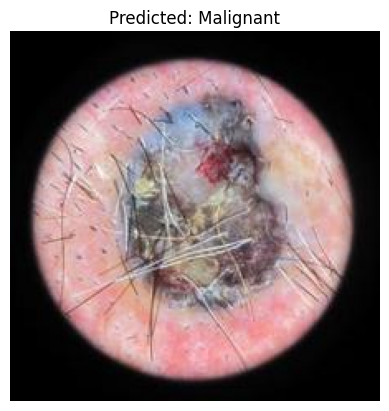

In [17]:
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/test/Malignant/5616.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


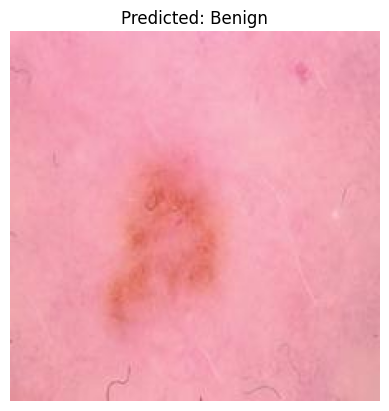

In [19]:
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/train/Benign/1004.jpg", model)